# 머신 러닝 교과서 3판

# 6장 - 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 파이프라인을 사용한 효율적인 워크플로
  - 위스콘신 유방암 데이터셋
  - 파이프라인으로 변환기와 추정기 연결
- k-겹 교차 검증을 사용한 모델 성능 평가
  - 홀드아웃 방법
  - k-겹 교차 검증
- 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅
  - 학습 곡선으로 편향과 분산 문제 분석
  - 검증 곡선으로 과대적합과 과소적합 조사
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
  - 그리드 서치를 사용한 하이퍼파라미터 튜닝
  - 중첩 교차 검증을 사용한 알고리즘 선택
- 여러 가지 성능 평가 지표
  - 오차 행렬
  - 분류 모델의 정밀도와 재현율 최적화
  - ROC 곡선 그리기
  - 다중 분류의 성능 지표
- 불균형한 클래스 다루기
- 요약

<br>
<br>

In [1]:
# 코랩에서 실행할 경우 최신 버전의 사이킷런을 설치합니다.
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.2MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
from IPython.display import Image

# 파이프라인을 사용한 효율적인 워크플로

...

## 위스콘신 유방암 데이터셋

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

<hr>

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
le.transform(['M', 'B'])

array([1, 0])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

<br>
<br>

## 파이프라인으로 변환기와 추정기 연결

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [9]:
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [10]:
Image(url='https://git.io/JtsTr', width=500) 

<br>
<br>

# k-겹 교차 검증을 사용한 모델 성능 평가

...

## 홀드아웃 방법

In [11]:
Image(url='https://git.io/JtsTo', width=500) 

<br>
<br>

## K-겹 교차 검증

In [12]:
Image(url='https://git.io/JtsT6', width=500) 

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [15]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


`cross_val_predict` 함수는 `cross_val_score`와 비슷한 인터페이스를 제공하지만 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환합니다. 따라서 `cross_val_predict` 함수의 결과를 사용해 모델의 성능(예를 들어, 정확도)을 계산하면 `cross_val_score` 함수의 결과와 다르며 바람직한 일반화 성능 추정이 아닙니다. `cross_val_predict` 함수의 사용 용도는 훈련 세트에 대한 예측 결과를 시각화하거나 7장에서 소개하는 스태킹(Stacking) 앙상블(Ensemble) 방법처럼 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용합니다.

In [16]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

`method` 매개변수에 반환될 값을 계산하기 위한 모델의 메서드를 지정할 수 있습니다. 예를 들어 `method='predict_proba'`로 지정하면 예측 확률을 반환합니다. `‘predict’`, `‘predict_proba’`, `‘predict_log_proba’`, `‘decision_function’` 등이 가능하며 기본값은 `'predict'`입니다.

In [17]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          method='predict_proba', 
                          n_jobs=-1)
preds[:10]

array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

<br>
<br>

# 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

<br>
<br>

## 학습 곡선으로 편향과 분산 문제 분석

In [18]:
Image(url='https://git.io/JtsTi', width=600) 

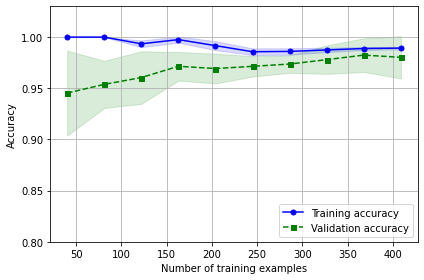

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

<br>
<br>

## 검증 곡선으로 과대적합과 과소적합 조사

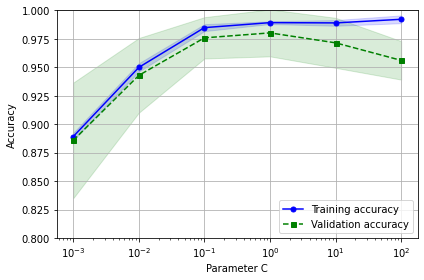

In [20]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

<br>
<br>

# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

<br>
<br>

## 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [22]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


`GridSearchCV` 클래스와 `cross_valiate` 함수에서 `return_train_score` 매개변수를 `True`로 지정하면 훈련 폴드에 대한 점수를 계산하여 반환합니다. 훈련 세트에 대한 점수를 보고 과대적합과 과소적합에 대한 정보를 얻을 수 있지만 실행 시간이 오래 걸릴 수 있습니다. `param_range`에 8개의 값이 지정되어 있기 때문에 `SVC` 모델은 `'linear'` 커널에 대해 8번, `'rbf'` 커널에 대해 64번 교차 검증이 수행됩니다. 따라서 훈련 폴드마다 반환되는 점수는 총 72개입니다. 이 값은 `GridSearchCV` 클래스의 `cv_results_` 딕셔너리 속성에 split{폴드번호}_train_score 와 같은 키에 저장되어 있습니다. 예를 들어 첫 번째 폴드의 점수는 `'split0_train_score'` 키로 저장되어 있습니다.

In [23]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [24]:
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

전체 훈련 점수의 평균 값은 `'mean_train_score'` 키에 저장되어 있습니다.

In [25]:
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

비슷하게 첫 번째 폴드에 대한 테스트 점수는 `'split0_test_score'` 키에 저장되어 있습니다.

In [26]:
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

`GridSearchCV` 클래스의 객체에서도 최종 모델의 `score`, `predict`, `transform` 메서드를 바로 호출할 수 있습니다.

In [27]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


매개변수 탐색 범위가 넓거나 규제 매개변수 `C`와 같이 연속적인 값을 탐색해야 하는 경우에 `RandomizedSearchCV`가 더 효율적입니다. 이 클래스는 `n_iter` 매개변수로 탐색 횟수를 조정할 수 있어 컴퓨팅 자원에 맞게 탐색을 실행할 수 있습니다. `GridSearchCV` 클래스에는 탐색할 매개변수 값을 리스트로 전달했습니다. `RandomizedSearchCV`에는 샘플링 가능한 분포를 지정해야 합니다. 예를 들면 `scipy.stats.uniform`, `scipy.stats.randint` 객체 등이 있습니다. 사이킷런 0.22 버전에서 `scipy.stats.reciprocal`을 사용한 로그 균등 분포(log-uniform distribution) 클래스 `loguniform`을 제공합니다.

다음 예에서 그리드 서치에서 사용한 것과 동일한 범위로 매개변수 `C`를 탐색해 보겠습니다. 대신 여기에서는 탐색 횟수를 30회로 줄여서 수행합니다.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution =  loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


결과에서 알 수 있듯이 `RandomizedSearchCV`의 탐색 횟수는 절반 이상 적지만 거의 비슷한 성능을 내는 매개변수 조합을 찾았습니다.

<br>
<br>

## 중첩 교차 검증을 사용한 알고리즘 선택

In [29]:
Image(url='https://git.io/JtsTP', width=500) 

In [30]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [31]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV 정확도: 0.934 +/- 0.016


<br>
<br>

# 여러 가지 성능 평가 지표

...

## 오차 행렬

In [32]:
Image(url='https://git.io/JtsT1', width=300) 

In [33]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


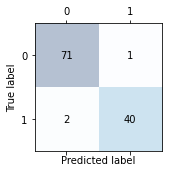

In [34]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
# plt.savefig('images/06_09.png', dpi=300)
plt.show()

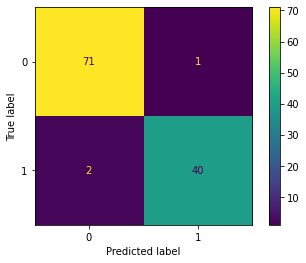

In [35]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)
# plt.savefig('images/06_plot_confusion_matrix.png', dpi=300)
plt.show()

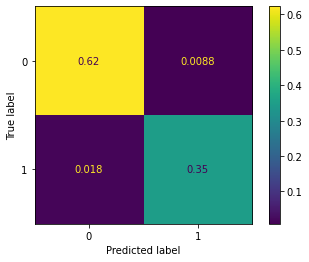

In [36]:
plot_confusion_matrix(pipe_svc, X_test, y_test, 
                      normalize='all')
# plt.savefig('images/06_plot_confusion_matrix_normalize.png', dpi=300)
plt.show()

### 추가 노트

앞서 클래스 레이블을 인코딩했기 때문에 *악성(malignant)* 종양이 "양성" 클래스(1), *양성(benign)* 종양이 "음성" 클래스(0)입니다:

In [37]:
le.transform(['M', 'B'])

array([1, 0])

그리고 다음처럼 오차 행렬을 출력했습니다:

In [38]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


클래스 0으로 올바르게 예측된 (진짜) 클래스 0 샘플(진짜 음성)이 행렬의 왼쪽 위에 있는 값입니다(인덱스 0,0). 진짜 음성이 오른쪽 아래(인덱스 1,1)에 있고 진짜 양성이 왼쪽 위에 있도록 순서를 바꾸려면 다음처럼 `labels` 매개변수를 사용합니다:

In [39]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


결론:

이 예에서 클래스 1(악성 종양)이 양성 클래스입니다. 모델은 71개의 샘플을 정확하게 클래스 0(진짜 음성)으로 분류했습니다. 40개의 샘플은 클래스 1(진짜 양성)로 올바르게 분류했습니다. 클래스 1에 해당하는 두 개의 샘플을 클래스 0(가짜 음성)으로 잘못 분류했고 양성 종양인 하나의 샘플을 악성 종양(가짜 양성)으로 잘못 분류했습니다.

<br>
<br>

## 분류 모델의 정밀도와 재현율 최적화

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [41]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


<br>
<br>

## ROC 곡선 그리기

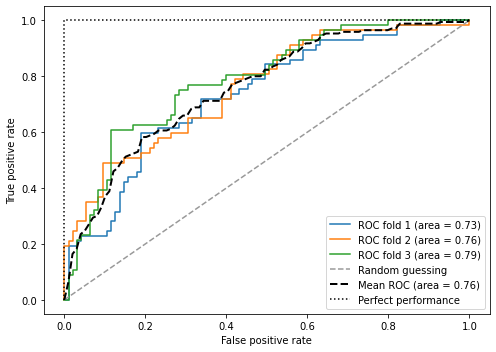

In [42]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

사이킷런 0.22 버전에서 `plot_roc_curve()` 함수와 `plot_precision_recall_curve()` 함수를 사용하면 ROC 곡선과 정밀도-재현율 곡선을 쉽게 그릴 수 있습니다.

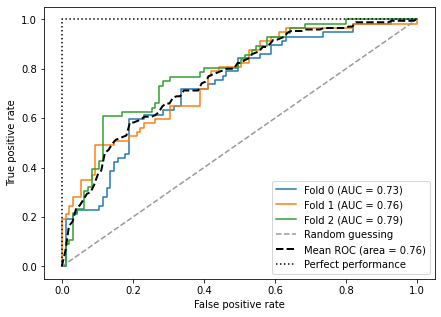

In [43]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = plot_roc_curve(pipe_lr, 
                              X_train2[test], y_train[test], 
                              name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
# plt.savefig('images/06_plot_roc_curve.png', dpi=300)
plt.show()

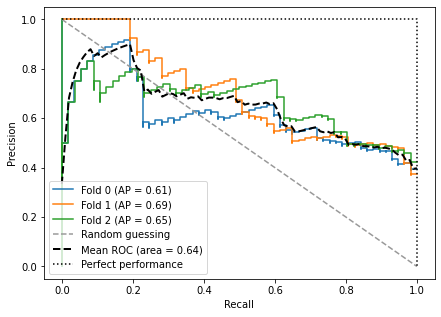

In [44]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = plot_precision_recall_curve(
        pipe_lr, X_train2[test], y_train[test], 
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], 
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
# plt.savefig('images/06_plot_precision_recall_curve.png', dpi=300)
plt.show()

<br>
<br>

## 다중 분류의 성능 지표

In [45]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# 불균형한 클래스 다루기

In [46]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [47]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [48]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [49]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [50]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

<br>
<br>